In [400]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from pytope import Polytope
import matplotlib.image as mpimg
import casadi as ca

In [401]:
data_id = "08"
track_id  = 14

background_filepath = f"../data/{data_id}_background.png"
recordingMeta_filepath = f"../data/{data_id}_recordingMeta.csv"
tracks_filepath = f"../data/{data_id}_tracks.csv"
tracksMeta_filepath = f"../data/{data_id}_tracksMeta.csv"
tracks_data = pd.read_csv(tracks_filepath)
filtered_data = tracks_data[tracks_data['trackId'] == track_id]

xAcc = filtered_data['xAcceleration'].to_numpy()
yAcc = filtered_data['yAcceleration'].to_numpy()
# xAcc = filtered_data['lonAcceleration'].to_numpy()
# yAcc = filtered_data['latAcceleration'].to_numpy()
acc_vals= np.vstack((xAcc,yAcc))
N_Sam = acc_vals.shape[1]

xPos = filtered_data["xCenter"].to_numpy()
yPos = filtered_data["yCenter"].to_numpy()
position_vals = np.vstack((xPos,yPos))

xVel = filtered_data["xVelocity"].to_numpy()
yVel = filtered_data["yVelocity"].to_numpy()
# xVel = filtered_data["lonVelocity"].to_numpy()
# yVel = filtered_data["latVelocity"].to_numpy()
velocity_vals = np.vstack((xVel,yVel))

yaw = filtered_data["heading"].to_numpy()

In [402]:
road_vertices = np.array([
    [270, -78],
    [338, -15],
    [786, -657],
    [857, -592]
])
Drive_Area = Polytope(road_vertices*(0.00814636091724916*12))
Drive_Area_visual = Polytope(road_vertices)
A_road = Drive_Area.A
b_road = Drive_Area.b
print(Drive_Area.A)
print(Drive_Area.b)

[[-0.74655504 -0.66532366]
 [ 0.67525407 -0.73758521]
 [-0.67962312  0.73356146]
 [ 0.74348633  0.66875113]]
[[-14.63164119]
 [ 99.25622409]
 [-23.53151648]
 [ 23.58538766]]


In [403]:
image_param = {
  "datasets": {
    "ind": {
      "scale_down_factor": 12,  
      "relevant_areas": { 
        "1": {
          "x_lim": [2000, 11500],  
          "y_lim": [9450, 0]  
        },
        "2": {
          "x_lim": [0, 12500],
          "y_lim": [7400, 0]
        },
        "3": {
          "x_lim": [0, 11500],
          "y_lim": [9365, 0]
        },
        "4": {
          "x_lim": [2700, 15448],
          "y_lim": [9365, 0]
        }
      }
    }
  }
}

x_lim_0 = 2000/12
x_lim_1 = 11500/12
y_lim_0 = 9450/12
y_lim_1 = 0/12

In [404]:
Param = {
    "init_acc": acc_vals[:,0].reshape(2,1),
    "N": 5, # Reachability Prediction Length
    "T": 0.25, # Sampling Interval
    "radius": 8,
    "num_vertices": 4,
    "l_f": 1.5, # Distance from CoG to Front Axle
    "l_r": 1.5, # Distance from CoG to Rear Axle
    "l_veh": 4.7, # length of vehicle
    "w_veh": 1.8, # width of vehicle
    "DEV": 5,
    "Q1": 1, # steering wheel angle
    "Q2": 1, # longitudinal jerk
    "Q3": 1, # long. velocity error
    "Q4": 5, # long. pos. error
    "Q5": 5, # lat. pos. error
    "Q6": 2, # heading. error
    "Q7": 300,
    "d_min": 2,
    "A_road": A_road,
    "b_road": b_road,
    "v_low": 0,
    "v_up": 5,
    "acc_low": -1,
    "acc_up": 1,
    "delta_low": -0.38,
    "delta_up": 0.38,
    "RefSpeed": 0,
    "RefPos": [34,-4.6,0]
}

In [405]:
class polytope_estimation_OR():
    def __init__(self, Param):
        #self.nu = Param["nu"]
        self.SV_Acc = Param["init_acc"]
        self.N = Param["N"] 
        self.T = Param["T"] 
        self.radius = Param["radius"]
        self.num_vertices = Param["num_vertices"]
        self.l_f = Param["l_f"] 
        self.l_r = Param["l_r"] 
        self.l_veh = Param["l_veh"] 
        self.w_veh = Param["w_veh"] 
        self.DEV = Param["DEV"]
        self.Q1 = Param["Q1"]
        self.Q2 = Param["Q2"]
        self.Q3 = Param["Q3"]
        self.Q4 = Param["Q4"]
        self.Q5 = Param["Q5"]
        self.Q6 = Param["Q6"]
        self.Q7 = Param["Q7"]
        self.d_min = Param["d_min"]
        self.A_road = Param["A_road"]
        self.b_road = Param["b_road"]
        self.v_low = Param["v_low"]
        self.v_up = Param["v_up"]
        self.acc_low = Param["acc_low"]
        self.acc_up = Param["acc_up"]
        self.delta_low = Param["delta_low"]
        self.delta_up = Param["delta_up"]
        self.RefSpeed = Param["RefSpeed"]
        self.RefPos = Param["RefPos"]
        
        self.U_SV_Poly = self.Generate_Polytope(self.radius,self.num_vertices)
        self.H = self.U_SV_Poly.A 
        self.h = self.U_SV_Poly.b 
        self.nv = np.size(self.H, 0)
        self.nu = np.size(self.H, 1)
        for i in range(self.nv):
            self.H[i,:] /= self.h[i]
        self.h = np.ones_like(self.h)
        self.N_Sam = self.SV_Acc.shape[1]

        self.LP = self.OR_LP()
        self.theta_pre,self.y_pre,self.rho_pre = self.LP(np.array([[0],[0]]),np.zeros((self.nu,1)),0.1*np.ones((self.nv,1)))
        self.MPC = self.MPCFormulation()

    def Return(self,SV_Acc_new, SV_Pos_new, SV_Vel_new, current_x_EV):
        RefSpeed = self.RefSpeed
        RefPos = self.RefPos
        G, g, Occupancy_SV = self.ReachableSet(SV_Acc_new, SV_Pos_new, SV_Vel_new)
        RefXPos = RefPos[0]
        RefYPos = RefPos[1]
        RefPhi  = RefPos[2]
        Trajectory_k, Control_k, J_k, s_k = self.MPC(G, g, current_x_EV, RefSpeed, RefXPos, RefYPos, RefPhi)
        Trajectory_k = Trajectory_k.full( )
        Control_k = Control_k.full( )

        return Control_k[:, 0], Trajectory_k, J_k.full( ), Occupancy_SV

    def ReachableSet(self,SV_Acc_new, SV_Pos_new, SV_Vel_new):
        self.U_Hat_Poly = self.OR(SV_Acc_new)

        A_SV = np.array([[1, self.T, 0, 0], [0, 1, 0, 0], [0, 0, 1, self.T], [0, 0, 0, 1]])
        B_SV = np.array([[0.5*self.T**2, 0], [self.T, 0], [0, 0.5*self.T**2], [0, self.T]])
        BU = B_SV*self.U_Hat_Poly
        Reachable_Set = list()
        Occupancy_SV = list()
        x_t = np.array([SV_Pos_new[0], SV_Vel_new[0], SV_Pos_new[1], SV_Vel_new[1]])
        Reachable_Set.append(x_t)
        G = np.zeros((4, 2*self.N)) 
        g = np.zeros((4, self.N))

        for t in range(1,self.N+1):
            if t == 1:
                reachable_set_t = (A_SV@Reachable_Set[t - 1] + BU) 
            else:
                reachable_set_t = (A_SV*Reachable_Set[t - 1] + BU) 
            
            vertex = reachable_set_t.V
            vertex_xy = np.delete(vertex, [1, 3], axis = 1)
            occupancy_SV_t = Polytope(vertex_xy) 
            occupancy_SV_t.minimize_V_rep( )
            temp_poly   = occupancy_SV_t
            G[:, 2*t-2:2*t] = temp_poly.A
            g[:, t-1]       = temp_poly.b.reshape(4, )

            Occupancy_SV.append(temp_poly)
            Reachable_Set.append(reachable_set_t)

        return G, g, Occupancy_SV

    def MPCFormulation(self):
        d_min = self.d_min          #minimum distance
        N = self.N                  #prediction length
        DEV = self.DEV              #dimension
        T = self.T                  #sampling interval
        Q1 = self.Q1                #weighting matrix steering wheel angle
        Q2 = self.Q2                #weighting matrix longitudinal jerk
        Q3 = self.Q3                #weighting matrix long. velocity error
        Q4 = self.Q4                #weighting matrix long. pos. error
        Q5 = self.Q5                #weighting matrix lat. pos. error
        Q6 = self.Q6                #weighting matrix heading. error
        Q7 = self.Q7                #weighting matrix slack variable
        A_road = self.A_road        #driving area.A
        b_road = self.b_road        #driving area.B
        v_low = self.v_low 
        v_up = self.v_up 
        acc_low = self.acc_low 
        acc_up = self.acc_up 
        delta_low = self.delta_low 
        delta_up = self.delta_up

        opti = ca.Opti( )
        X = opti.variable(DEV, N + 1)
        U = opti.variable(2, N)
        delta = U[0, :]
        eta   = U[1, :]
        lam = opti.variable(4, N)
        s   = opti.variable(N, 1)

        G = opti.parameter(4, 2*N)
        g = opti.parameter(4, N)
        Initial = opti.parameter(DEV, 1)
        v_ref = opti.parameter( )
        x_ref = opti.parameter( )
        y_ref = opti.parameter( )
        phi_ref = opti.parameter( )
        
        opti.subject_to(X[:, 0] == Initial)
        for k in range(N):
            k1 = self.vehicle_model(X[:, k], delta[k], eta[k])
            k2 = self.vehicle_model(X[:, k] + T/2*k1, delta[k], eta[k])
            k3 = self.vehicle_model(X[:, k] + T/2*k2, delta[k], eta[k])
            k4 = self.vehicle_model(X[:, k] + T*k3, delta[k], eta[k])
            x_next = X[:, k] + T/6 * (k1 + 2*k2 + 2*k3 + k4)
            opti.subject_to(X[:, k + 1] == x_next) 
        x = X[0, 1::]
        y = X[1, 1::]
        phi = X[2, 1::]
        v = X[3, 1::]
        a = X[4, 1::]
        phi_error = phi[-1] - phi_ref
        v_error = v[-1] - v_ref # longitudinal speed error
        x_error = x[-1] - x_ref # longitudinal position error
        y_error = y[-1] - y_ref # lateral position error
        # collision-avoidance
        for k in range(N):
            p_point = X[0:2, k + 1]
            
            G_point = G[:, 2*k:2*k + 2]
            g_point = g[:, k]
            temp = G_point.T@lam[:, k]
            opti.subject_to((G_point@p_point - g_point).T@lam[:, k] >= d_min - s[k])
            opti.subject_to(temp[0]**2 + temp[1]**2 == 1)
            opti.subject_to(0 <= lam[:, k])
            opti.subject_to(A_road@p_point <= b_road)

        opti.subject_to(opti.bounded(0, s, d_min))
        opti.subject_to(opti.bounded(-v_up, v, v_up))
        opti.subject_to(opti.bounded(acc_low, a, acc_up))
        opti.subject_to(opti.bounded(delta_low, delta, delta_up))
        
        J = delta@Q1@delta.T + eta@Q2@eta.T + Q3*v_error@v_error.T + Q4*x_error@x_error.T + Q5*y_error@y_error.T + Q6*phi_error@phi_error.T + Q7*s.T@s
        opti.minimize(J)
        
        opts = {"ipopt.print_level": 1, "ipopt.linear_solver": "ma57", "print_time": False} #"ipopt.linear_solver": "ma57",
        opti.solver('ipopt', opts)

        return opti.to_function('g', [G, g, Initial, v_ref, x_ref, y_ref, phi_ref], [X, U, J, s])
    
    def  vehicle_model(self, w, delta, eta):

        l_f = self.l_f
        l_r = self.l_r
        
        beta = np.arctan(l_r/(l_f + l_r)*np.tan(delta))
        x_dot   = w[3]*np.cos(w[2] + beta) 
        y_dot   = w[3]*np.sin(w[2] + beta)
        phi_dot = w[3]/(l_r)*np.sin(beta)
        v_dot = w[4]
        a_dot = eta
        
        return ca.vertcat(x_dot, y_dot, phi_dot, v_dot, a_dot)

    def Generate_Polytope(self, radius, num_vertices):
        if num_vertices != 4:
            angles = np.linspace(0, 2 * np.pi, num_vertices, endpoint=False)
            x_coords = radius * np.cos(angles)
            y_coords = radius * np.sin(angles)

            vertices = np.column_stack((x_coords, y_coords))
            U_SV_Poly = Polytope(vertices)

            return U_SV_Poly
        else:
            low_bound_control  = (-radius, -radius)
            up_bound_control   = (radius,   radius)
            U_SV_Poly = Polytope(lb = low_bound_control, ub = up_bound_control)
            return U_SV_Poly  

    def OR_LP(self):
        H = self.H
        nv = self.nv
        nu = self.nu

        opti = ca.Opti()

        rho = opti.variable()
        theta = opti.variable(nv,1)
        y = opti.variable(nu,1)

        samples = opti.parameter(nu, 1)
        y_pre = opti.parameter(nu,1)
        theta_pre = opti.parameter(nv,1)

        opti.minimize(rho + np.ones((1, nv))@theta)

        opti.subject_to(H @ samples-H @ y <= theta)
        opti.subject_to(H @ y_pre + theta_pre <= H @ y + theta)
        opti.subject_to(H @ y <= (1 - rho)@np.ones((nv,1)))
        opti.subject_to(opti.bounded(0, theta, 1))
        opti.subject_to(opti.bounded(0, rho, 1))
        opti.subject_to(theta <= rho@np.ones((nv,1)))

        opts = {"ipopt.print_level": 0, "print_time": False}
        opti.solver('ipopt', opts)

        return opti.to_function('f', [samples, y_pre, theta_pre], [theta, y, rho])    

    def OR(self,SV_Acc_new):
        self.theta_pre,self.y_pre,self.rho_pre = self.LP(SV_Acc_new,self.y_pre,self.theta_pre)
        U_Hat_Poly = Polytope(self.H, self.theta_pre)+self.y_pre

        return U_Hat_Poly
    
    def Plot_Polytope(self):
        plt.figure()
        self.U_SV_Poly.plot(color = 'b', alpha = 0.3)

        self.U_Hat_Poly.plot(color = 'r', alpha = 0.3)

        #sample points
        plt.scatter(self.SV_Acc[0,:],self.SV_Acc[1,:],marker='x',color = 'black')

        # y
        # y_s_coodinate = np.array(y_hat)
        # plt.scatter(y_s_coodinate[0], y_s_coodinate[1], marker='x',color='red')

        #convexhull
        # points = self.SV_Acc.T
        # hull = ConvexHull(points)
        # for simplex in hull.simplices:
        #     plt.plot(points[simplex, 0], points[simplex, 1], 'r-')

        plt.gca().set_aspect('equal', adjustable='box')
        plt.title("Polytope Visualization")
        plt.xlabel("Long Acc")
        plt.ylabel("Lat Acc")
        plt.grid(True)
        plt.show()

    def vehicle_model(self, w, delta, eta):

        l_f = self.l_f
        l_r = self.l_r
        
        beta = np.arctan(l_r/(l_f + l_r)*np.tan(delta))
        x_dot   = w[3]*np.cos(w[2] + beta) 
        y_dot   = w[3]*np.sin(w[2] + beta)
        phi_dot = w[3]/(l_r)*np.sin(beta)
        v_dot = w[4]
        a_dot = eta
        
        return ca.vertcat(x_dot, y_dot, phi_dot, v_dot, a_dot)

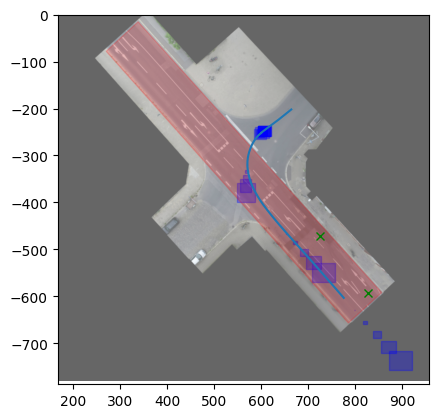

In [406]:
#test occupancy
lp_time = []
test_polytope = polytope_estimation_OR(Param)

SV_x = filtered_data["xCenter"].to_numpy()
SV_y = filtered_data["yCenter"].to_numpy()
fig, ax = plt.subplots()
img   = mpimg.imread(background_filepath)

for i in range(1,N_Sam):
    start_time = time.time() 
    G,g,tmp = test_polytope.ReachableSet(acc_vals[:,i].reshape(2,1),
                                         position_vals[:,i].reshape(2,1),
                                         velocity_vals[:,i].reshape(2,1))
    end_time = time.time()
    lp_time.append(end_time-start_time)
    
    if i % 50 == 0 or i == N_Sam-1:
        for i in range(5):
            occupancy = Polytope(tmp[i].A, tmp[i].b/0.00814636091724916/12)
            occupancy.plot(color = 'b', alpha = 0.3)

Drive_Area_visual.plot(color = 'r', alpha = 0.2)

plt.imshow(img,alpha = 0.6, extent=[0, img.shape[1], -img.shape[0], 0])
plt.plot(SV_x/0.00814636091724916/12, SV_y/0.00814636091724916/12)
plt.plot(81/0.00814636091724916/12, -58/0.00814636091724916/12,'gx')
plt.plot(71/0.00814636091724916/12, -46/0.00814636091724916/12,'gx')
ax.set_xlim([x_lim_0,x_lim_1])
ax.set_ylim([-y_lim_0,-y_lim_1])
# ax.set_xlim([0,1500])
# ax.set_ylim([-1500,0])
plt.show()

Exception of type: DYNAMIC_LIBRARY_FAILURE in file "/Users/runner/work/casadi/casadi/build/external_projects/src/ipopt-external/src/Common/IpLibraryLoader.cpp" at line 72:
 Exception message: dlopen(libhsl.dylib, 0x0002): tried: 'libhsl.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibhsl.dylib' (no such file), '/Users/qdzhou/CourseWork/FYP/fyp_env/lib/python3.12/site-packages/casadi/libhsl.dylib' (no such file), '/opt/homebrew/lib/libhsl.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libhsl.dylib' (no such file), '/usr/lib/libhsl.dylib' (no such file, not in dyld cache), 'libhsl.dylib' (no such file), '/usr/local/lib/libhsl.dylib' (no such file), '/usr/lib/libhsl.dylib' (no such file, not in dyld cache)
Exception of type: DYNAMIC_LIBRARY_FAILURE in file "/Users/runner/work/casadi/casadi/build/external_projects/src/ipopt-external/src/Common/IpLibraryLoader.cpp" at line 72:
 Exception message: dlopen(libhsl.dylib, 0x0002): tried: 'libhsl.dyli

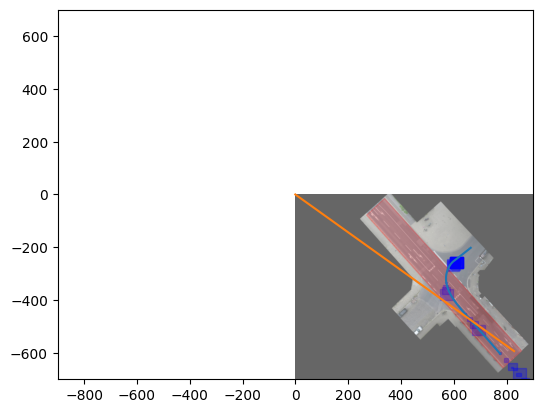

In [407]:
#test mpc
test_polytope1 = polytope_estimation_OR(Param)
State_EV_R     = np.zeros((5, 1000))
#829 -603
x_EV_initial = np.array([81, -58, 0, 0, 0]) 
State_EV_R[:, 0] = x_EV_initial
X_EV_Planning_R = list( )

fig, ax = plt.subplots()
img   = mpimg.imread(background_filepath)

for i in range(1,N_Sam):
    #   U_R: input, trajectory_planning_k: predicted EV, J_R:cost, Occupancy_SV_aug_R:Occupancy
    U_R, trajectory_planning_k, J_R, Occupancy_SV_aug_R = test_polytope.Return(acc_vals[:,i].reshape(2,1),
                                                                                        position_vals[:,i].reshape(2,1),
                                                                                        velocity_vals[:,i].reshape(2,1),
                                                                                        State_EV_R[:, i])
    X_EV_Planning_R.append(trajectory_planning_k)
    State_EV_R[:, i + 1] = trajectory_planning_k[:, 1]
    #print(trajectory_planning_k)
    if i % 40 == 0 or i == N_Sam-1:
        for i in range(5):
            occupancy = Polytope(Occupancy_SV_aug_R[i].A, Occupancy_SV_aug_R[i].b/0.00814636091724916/12)
            occupancy.plot(color = 'b', alpha = 0.3)
            
Drive_Area_visual.plot(color = 'r', alpha = 0.2)
plt.imshow(img,alpha = 0.6, extent=[0, img.shape[1], -img.shape[0], 0])
plt.plot(SV_x/0.00814636091724916/12, SV_y/0.00814636091724916/12)
plt.plot(State_EV_R[0]/0.00814636091724916/12, State_EV_R[1]/0.00814636091724916/12)
# ax.set_xlim([x_lim_0,x_lim_1])
# ax.set_ylim([-y_lim_0,-y_lim_1])
ax.set_xlim([-900,900])
ax.set_ylim([-700,700])
plt.show()

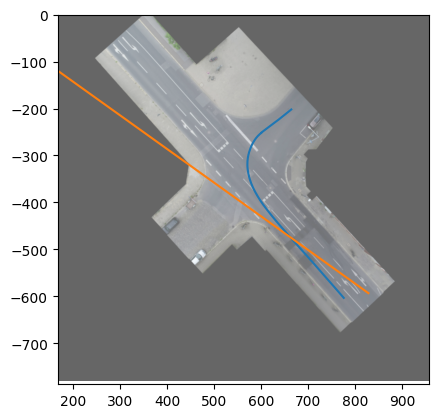

In [408]:
fig, ax = plt.subplots()
plt.imshow(img,alpha = 0.6, extent=[0, img.shape[1], -img.shape[0], 0])
plt.plot(SV_x/0.00814636091724916/12, SV_y/0.00814636091724916/12)
plt.plot(State_EV_R[0]/0.00814636091724916/12, State_EV_R[1]/0.00814636091724916/12)
ax.set_xlim([x_lim_0,x_lim_1])
ax.set_ylim([-y_lim_0,-y_lim_1])
plt.show()